# **Dataset Analysis**


## DrugBank

In [25]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def process_drugbank_xml(xml_file):
    """Extract drug descriptions from DrugBank XML"""
    ns = {'db': 'http://www.drugbank.ca'}
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    descriptions = {}
    for drug in root.findall('db:drug', ns):
        # Get all possible names for the drug
        names = []
        
        # Primary name
        name = drug.find('db:name', ns)
        if name is not None:
            names.append(name.text.lower())
        
        # Synonyms
        for synonym in drug.findall('.//db:synonym', ns):
            names.append(synonym.text.lower())
            
        # Products
        for product in drug.findall('.//db:product', ns):
            name_element = product.find('.//db:name', ns)
            if name_element is not None:
                names.append(name_element.text.lower())
        
        # Get description
        desc_elem = drug.find('db:description', ns)
        if desc_elem is not None and desc_elem.text:
            desc = desc_elem.text.strip()
            # Add description for all names of this drug
            for name in names:
                descriptions[name] = desc
    
    return descriptions

In [3]:
# Load drug descriptions from DrugBank
descriptions = process_drugbank_xml('../full database.xml')
print(f"Loaded {len(descriptions)} drug descriptions")

Loaded 161137 drug descriptions


In [7]:
drugbank_df = pd.DataFrame(list(descriptions.items()), columns=['Drug Name', 'Description'])

# Display basic info
print(drugbank_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161137 entries, 0 to 161136
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Drug Name    161137 non-null  object
 1   Description  161137 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB
None


In [8]:
drugbank_df.head()

,Drug Name,Description
0,lepirudin,Lepirudin is a recombinant hirudin formed by 6...
1,"[leu1, thr2]-63-desulfohirudin",Lepirudin is a recombinant hirudin formed by 6...
2,desulfatohirudin,Lepirudin is a recombinant hirudin formed by 6...
3,hirudin variant-1,Lepirudin is a recombinant hirudin formed by 6...
4,lepirudin recombinant,Lepirudin is a recombinant hirudin formed by 6...


In [ ]:
# Print the first 10 for demonstration
for name, desc in list(descriptions.items())[:10]:
    print(f"{name}: {desc}")

lepirudin: Lepirudin is a recombinant hirudin formed by 65 amino acids that acts as a highly specific and direct thrombin inhibitor.[L41539,L41569] Natural hirudin is an endogenous anticoagulant found in _Hirudo medicinalis_ leeches.[L41539] Lepirudin is produced in yeast cells and is identical to natural hirudin except for the absence of sulfate on the tyrosine residue at position 63 and the substitution of leucine for isoleucine at position 1 (N-terminal end).[A246609] 

Lepirudin is used as an anticoagulant in patients with heparin-induced thrombocytopenia (HIT), an immune reaction associated with a high risk of thromboembolic complications.[A3, L41539] HIT is caused by the expression of immunoglobulin G (IgG) antibodies that bind to the complex formed by heparin and platelet factor 4. This activates endothelial cells and platelets and enhances the formation of thrombi.[A246609] Bayer ceased the production of lepirudin (Refludan) effective May 31, 2012.[L41574]
[leu1, thr2]-63-desul

In [9]:
print("Total unique drugs:", drugbank_df['Drug Name'].nunique())

Total unique drugs: 161137


In [ ]:
drugbank_df['Description Length'] = drugbank_df['Description'].apply(lambda x: len(x.split()))
print(drugbank_df[['Drug Name', 'Description Length']].describe())

       Description Length
count       161137.000000
mean            79.935266
std             72.920953
min              3.000000
25%             37.000000
50%             60.000000
75%            104.000000
max            887.000000


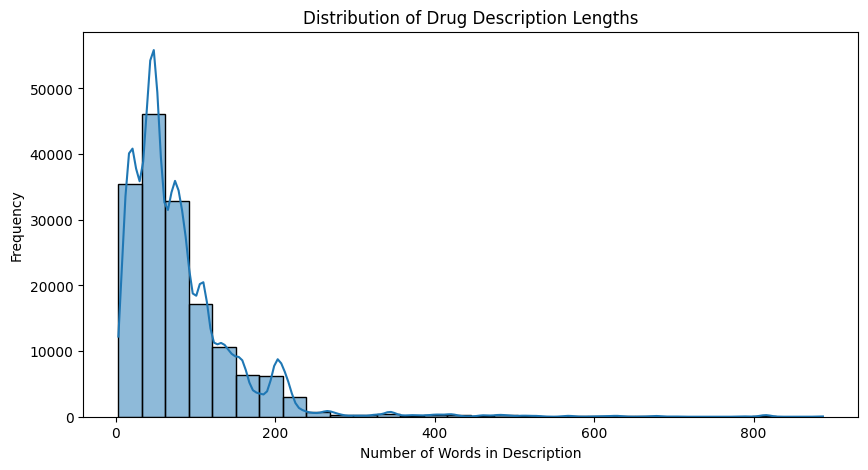

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(drugbank_df['Description Length'], bins=30, kde=True)
plt.xlabel('Number of Words in Description')
plt.ylabel('Frequency')
plt.title('Distribution of Drug Description Lengths')
plt.show()

## DrugBank in relation with DDICorpus


In [15]:
def parse_ddi_corpus(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    sentences = []
    entities = []

    for sentence in root.iter('sentence'):
        sent_text = sentence.attrib['text']
        sent_entities = []

        for entity in sentence.iter('entity'):
            ent_text = entity.attrib['text']
            ent_type = entity.attrib['type']
                        
            sent_entities.append({
                'text': ent_text,
                'type': ent_type,
            })

        sentences.append(sent_text)
        entities.append(sent_entities)

    return sentences, entities

def process_all_files_in_directory(directory):
    all_results = []
    # Iterate through all XML files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".xml"):
            file_path = os.path.join(directory, filename)
            
            sentences, entities = parse_ddi_corpus(file_path)

            all_results.append({'sentences': sentences, 'entities': entities})     
    
    return all_results

processed_files_1 = process_all_files_in_directory("../DDICorpus/Train/DrugBank")
processed_files_2 = process_all_files_in_directory("../DDICorpus/Train/MedLine")


def convert_to_dataframe(processed_files):
    data = []
    
    for entry in processed_files:
        sentences = entry["sentences"]
        entities = entry["entities"]
        
        for i, sentence in enumerate(sentences):
            entity_list = entities[i] if i < len(entities) else []
            
            entity_texts = [e["text"] for e in entity_list]
            entity_types = [e["type"] for e in entity_list]
            
            row = {"sentence": sentence}
            
            for idx, (text, type_) in enumerate(zip(entity_texts, entity_types)):
                row[f"entity_{idx+1}"] = text
                row[f"entity_{idx+1}_type"] = type_
            
            data.append(row)
    
    return pd.DataFrame(data)


df_1 = convert_to_dataframe(processed_files_1)
df_2 = convert_to_dataframe(processed_files_2)

df_train = pd.concat([df_1, df_2], ignore_index=True)
df_train

,sentence,entity_1,entity_1_type,entity_2,entity_2_type,entity_3,entity_3_type,entity_4,entity_4_type,entity_5,...,entity_51,entity_51_type,entity_52,entity_52_type,entity_53,entity_53_type,entity_54,entity_54_type,entity_55,entity_55_type
0,"No drug, nutritional supplement, food or herb ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,No formal drug/drug interaction studies with P...,Plenaxis,brand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Cytochrome P-450 is not known to be involved i...,Plenaxis,brand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Plenaxis is highly bound to plasma proteins (9...,Plenaxis,brand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Laboratory Tests Response to Plenaxis should b...,Plenaxis,brand,testosterone,drug,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6971,"When taken concurrently with ethanol, a pharma...",ethanol,drug,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6972,In addition to this pharmacological interactio...,temazepam,drug,benzodiazepine,group,ethanol,drug,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6973,"Optimal conditions, kinetics, equilibrium, and...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6974,The results raise the possibility that the eth...,alcohol,drug,"3-hydroxy-1,4-benzodiazepine",group,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Ensure Drug Name is lowercase for better matching
drugbank_df['Drug Name'] = drugbank_df['Drug Name'].str.lower()

# Reshape DDICorpus entity columns to a long format
ddicorpus_entities = pd.melt(df_train, id_vars=['sentence'], 
                             value_vars=[col for col in df_train.columns if 'entity_' in col and '_type' not in col],
                             var_name='entity_column', value_name='Drug Name').dropna()

# Merge with DrugBank descriptions
merged_df = ddicorpus_entities.merge(drugbank_df, on='Drug Name', how='left')

# Display the merged DataFrame
merged_df.head()


,sentence,entity_column,Drug Name,Description,Description Length
0,No formal drug/drug interaction studies with P...,entity_1,Plenaxis,NaN,NaN
1,Cytochrome P-450 is not known to be involved i...,entity_1,Plenaxis,NaN,NaN
2,Plenaxis is highly bound to plasma proteins (9...,entity_1,Plenaxis,NaN,NaN
3,Laboratory Tests Response to Plenaxis should b...,entity_1,Plenaxis,NaN,NaN
4,Serum transaminase levels should be obtained b...,entity_1,Plenaxis,NaN,NaN


In [ ]:
print(merged_df['Drug Name'].value_counts().head(10))

Drug Name
digoxin          209
warfarin         188
phenytoin        167
theophylline     134
lithium          120
ketoconazole     107
alcohol           93
cimetidine        93
cyclosporine      84
carbamazepine     83
Name: count, dtype: int64


In [21]:
missing_drugs = merged_df[merged_df['Description'].isna()]
print(missing_drugs[['Drug Name']].drop_duplicates())

                  Drug Name
0                  Plenaxis
5                   ORENCIA
6                       MTX
8            TNF antagonist
11                Abciximab
...                     ...
14744  somatostatin analogs
14747              Viracept
14755            Astramorph
14759                Kadian
14762             MS Contin

[2100 rows x 1 columns]


In [23]:
merged_df['Description Length'] = merged_df['Description'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
merged_df.sort_values('Description Length', ascending=False).head(10)


,sentence,entity_column,Drug Name,Description,Description Length
6568,plasma levels of several closely related tricy...,entity_2,methylphenidate,Methylphenidate is a central nervous system st...,677
14609,The most commonly occurring drug interactions ...,entity_15,methylphenidate,Methylphenidate is a central nervous system st...,677
14733,Drugs that reportedly may increase oral antico...,entity_29,methylphenidate,Methylphenidate is a central nervous system st...,677
470,methylphenidate;,entity_1,methylphenidate,Methylphenidate is a central nervous system st...,677
13224,Use lowest possible dose of atorvastatin with ...,entity_5,rosuvastatin,"Rosuvastatin, also known as the brand name pro...",568
13989,Interactions with Mixed Agonist/Antagonist Opi...,entity_7,buprenorphine,Buprenorphine is a weak partial mu-opioid rece...,567
904,Because CYP 3A4 inhibitors may increase plasma...,entity_1,buprenorphine,Buprenorphine is a weak partial mu-opioid rece...,567
906,"Based on anecdotal reports, there may be an in...",entity_1,buprenorphine,Buprenorphine is a weak partial mu-opioid rece...,567
907,There have been a number of reports in the pos...,entity_1,buprenorphine,Buprenorphine is a weak partial mu-opioid rece...,567
908,"In many of these cases, buprenorphine was misu...",entity_1,buprenorphine,Buprenorphine is a weak partial mu-opioid rece...,567


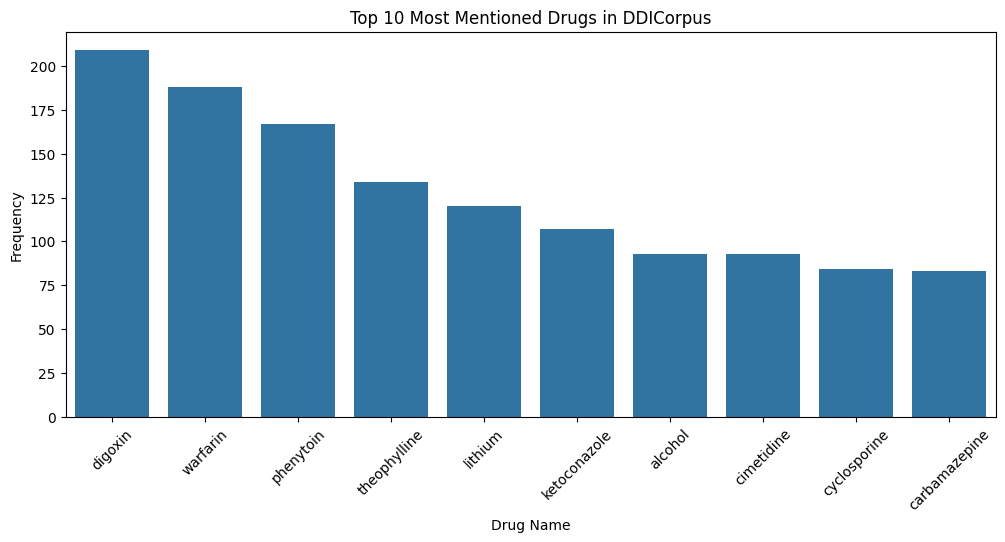

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(x=merged_df['Drug Name'].value_counts().head(10).index, 
            y=merged_df['Drug Name'].value_counts().head(10).values)
plt.xticks(rotation=45)
plt.xlabel("Drug Name")
plt.ylabel("Frequency")
plt.title("Top 10 Most Mentioned Drugs in DDICorpus")
plt.show()

In [ ]:
# Extract drug pairs from sentences
ddi_pairs = df_train.dropna(subset=['entity_1', 'entity_2'])[['entity_1', 'entity_2', 'sentence']]

# Check if both drugs exist in DrugBank
ddi_pairs_matched = ddi_pairs.merge(drugbank_df, left_on='entity_1', right_on='Drug Name', how='left')\
                             .merge(drugbank_df, left_on='entity_2', right_on='Drug Name', suffixes=('_1', '_2'), how='left')

# Display pairs where both drugs exist in DrugBank
ddi_pairs_matched.dropna(subset=['Description_1', 'Description_2'])

,entity_1,entity_2,sentence,Drug Name_1,Description_1,Description Length_1,Drug Name_2,Description_2,Description Length_2
6,heparin,warfarin,"These medications have included heparin, warfa...",heparin,Unfractionated heparin (UH) is a heterogenous ...,138.0,warfarin,Warfarin is an anticoagulant drug normally use...,125.0
10,disulfiram,diazepam,Pharmacokinetic studies indicate that administ...,disulfiram,A carbamate derivative used as an alcohol dete...,58.0,diazepam,"A benzodiazepine with anticonvulsant, anxiolyt...",173.0
29,digoxin,hydrochlorothiazide,"No significant interactions with digoxin, hydr...",digoxin,Digoxin is one of the oldest cardiovascular me...,106.0,hydrochlorothiazide,Hydrochlorothiazide is the most commonly presc...,55.0
41,probenecid,acyclovir,Co-administration of probenecid with acyclovir...,probenecid,The prototypical uricosuric agent. It inhibits...,49.0,acyclovir,Acyclovir is a deoxynucleoside analog antivira...,55.0
44,glibenclamide,acitretin,Repeating the study with 6 healthy male volunt...,glibenclamide,Glyburide is a second generation sulfonylurea ...,75.0,acitretin,An oral retinoid effective in the treatment of...,28.0
...,...,...,...,...,...,...,...,...,...
3773,cocaine,desipramine,This defect in the failing heart can be mimick...,cocaine,An alkaloid ester extracted from the leaves of...,76.0,desipramine,Desipramine hydrochloride is a dibenzazepine-d...,197.0
3774,norepinephrine,cocaine,Compromised norepinephrine uptake-1 in functio...,norepinephrine,Precursor of epinephrine that is secreted by t...,55.0,cocaine,An alkaloid ester extracted from the leaves of...,76.0
3776,pentagastrin,histamine,It was established that both angiotensins inhi...,pentagastrin,A synthetic pentapeptide that mimics the actio...,35.0,histamine,A depressor amine derived by enzymatic decarbo...,31.0
3785,temazepam,ethanol,Acid-catalyzed ethanolysis of temazepam in anh...,temazepam,"Temazepam, like many other similar and related...",181.0,ethanol,"A clear, colorless liquid rapidly absorbed fro...",50.0
